In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt


import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out import create_dir
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id


from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, \
latent_code_generator_two_layers

from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats
from tf_lab.point_clouds.convenience import get_latent_codes
# from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, \
#                                     point_cloud_distances, jensen_shannon_divergence, sample_pclouds_distances

from tf_lab.neural_net import MODEL_SAVER_ID

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_points = 2048
do_training = True
do_plotting = True
save_synthetic_samples = True
save_model = True
saver_step = 10  # TODO: Save only on [1,3,10,30,100,300,500]

ae_loss = 'chamfer'
class_name = raw_input('Give me the class type.\n').lower()
syn_id = snc_category_to_synth_id()[class_name]

b_neck = int(raw_input('Give me bneck_size.\n'))

experiment_tag = 'l_gan_test'
# experiment_tag = '_'.join(['l_gan', class_name, 'mlp_with_split_3pc_usampled', ae_loss, 'bneck', str(b_neck)])
# experiment_tag = '_'.join(['l_gan', class_name, 'mlp_with_split_1pc_usampled_no_bnorm_finish', ae_loss, 'bneck', str(b_neck)])
print experiment_tag

Give me the class type.
chair
Give me bneck_size.
32
l_gan_test


In [5]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
synthetic_data_out_dir = osp.join(top_data_dir, 'OUT/iclr/synthetic_samples/lgan')
train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models', experiment_tag)
create_dir(train_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/l_gan_test'

In [6]:
in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)

Loading test data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/test.txt
679 pclouds were loaded. They belong in 1 shape-classes.
Loading train data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/train.txt
5761 pclouds were loaded. They belong in 1 shape-classes.
Loading val data.
/orions4-zfs/projects/optas/DATA/Point_Clouds/Shape_Net/Splits/single_class_splits/03001627/85_5_10/val.txt
338 pclouds were loaded. They belong in 1 shape-classes.


In [11]:
ae_loss = 'emd'

In [35]:
# Load Auto-Encoder
# ae_experiment_tag = 'mlp_with_split_3pc_usampled'
ae_experiment_tag = 'mlp_with_split_1pc_usampled_no_bnorm_finish'
ae_id = '_'.join(['ae', class_name, ae_experiment_tag, str(n_pc_points), 'pts', str(b_neck), 'bneck', ae_loss])
ae_train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', ae_id)

ae_conf = Conf.load(osp.join(ae_train_dir, 'configuration'))

saved_epochs = read_saved_epochs(ae_conf.train_dir)
last_epoch = saved_epochs[-1]

# best_epoch = last_epoch
# best_epoch = 100

# # val_error, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(ae_train_dir, 'train_stats.txt'))
# # print val_error, best_epoch
# # if best_epoch % ae_conf.saver_step != 0: # Model was not saved at that epoch.
# #     best_epoch += best_epoch % conf.saver_step

ae_conf.encoder_args['verbose'] = False
ae_conf.decoder_args['verbose'] = False


reset_tf_graph()
ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)    
ae.restore_model(ae_conf.train_dir, best_epoch, verbose=True)

Model restored in epoch 100.


In [36]:
from tf_lab.point_clouds.convenience import reconstruct_pclouds
recon, loss_value = reconstruct_pclouds(ae, in_data['train'].point_clouds, 100)
print loss_value

102.320896103


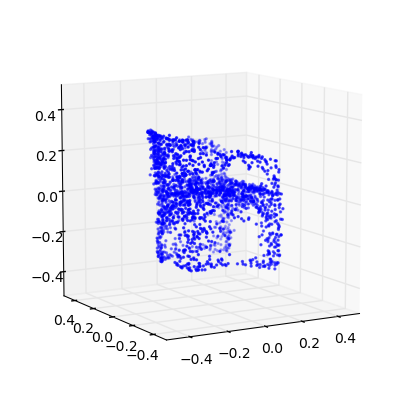

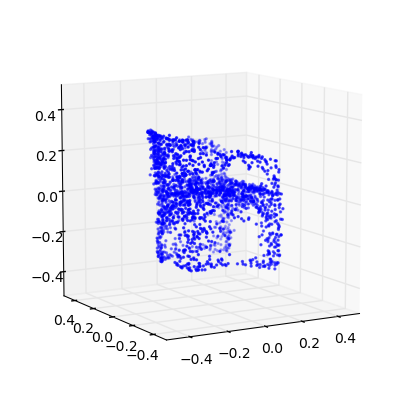

In [37]:
rid = np.random.randint(len(recon))
Point_Cloud(recon[rid]).plot()

In [38]:
# Convert raw-data to latent codes.
latent_codes = get_latent_codes(ae, in_data['train'].point_clouds)
train_data = PointCloudDataSet(latent_codes)

In [39]:
init_lr = 0.0001
batch_size = 50

noise_params = {'mu':0, 'sigma': 0.5}
beta = 0
noise_dim = b_neck
max_epochs = 500

n_syn_samples = train_data.num_examples / 3  # Same number as original GT data.
n_syn_samples = train_data.num_examples  # Same number as original GT data. !!

n_out = [b_neck]
accum_syn_data = []
train_stats = []

In [40]:
reset_tf_graph()
gan = LatentGAN(experiment_tag, init_lr, n_out, noise_dim, latent_code_discriminator_two_layers,
                latent_code_generator_two_layers, beta=beta, gen_kwargs={'b_norm': False}, 
                disc_kwargs={'b_norm': False})

1 (0.56490425312000769, 0.94208829817564588)


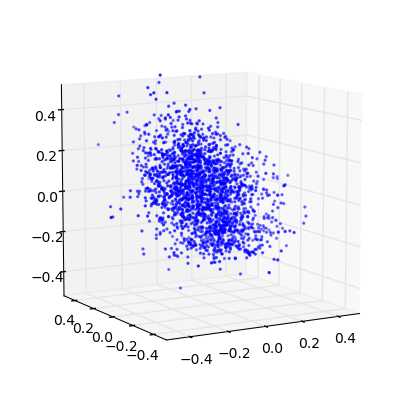

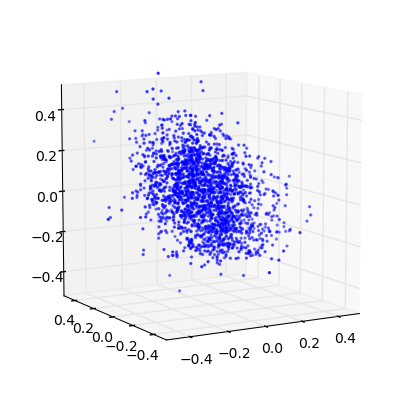

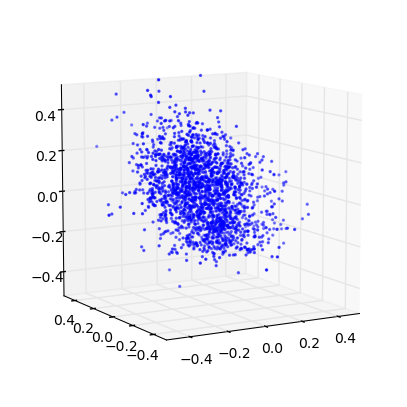

2 (0.17198444902896881, 1.9760455546171769)


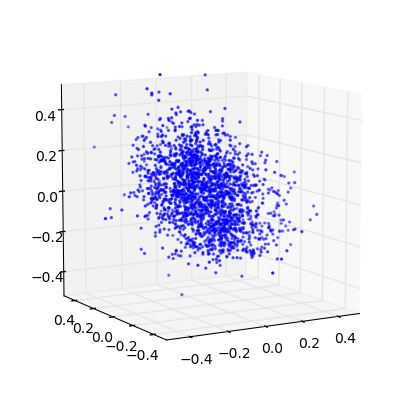

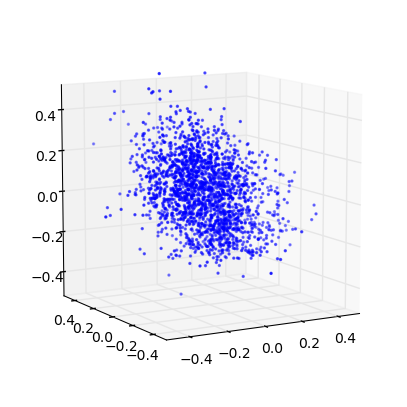

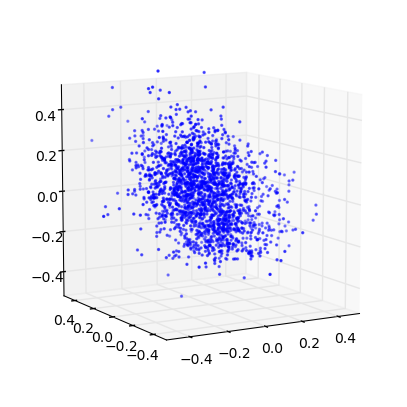

3 (0.045637984460462695, 3.2211945906929347)


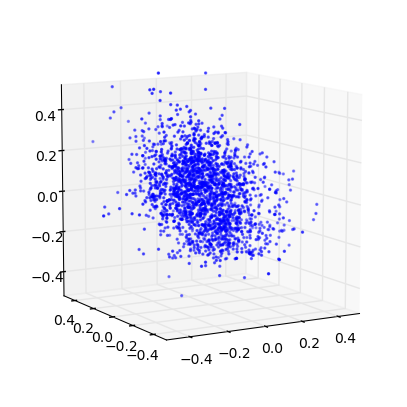

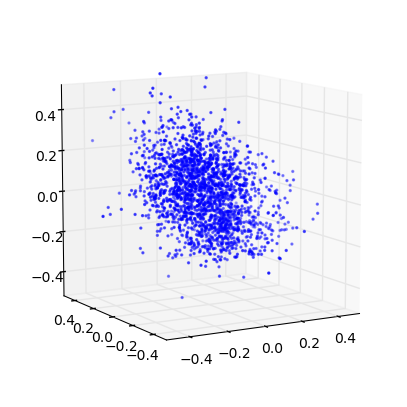

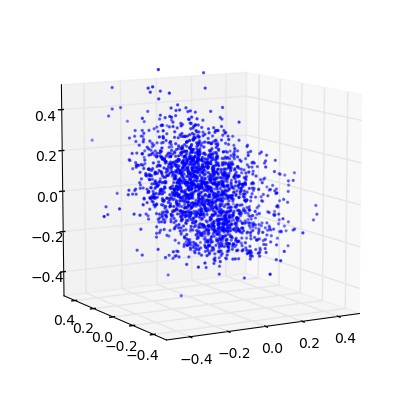

4 (0.015378345532909683, 4.2429448480191434)


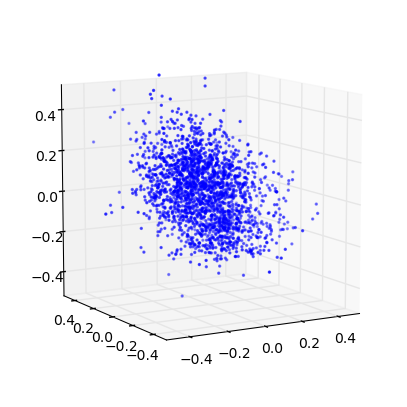

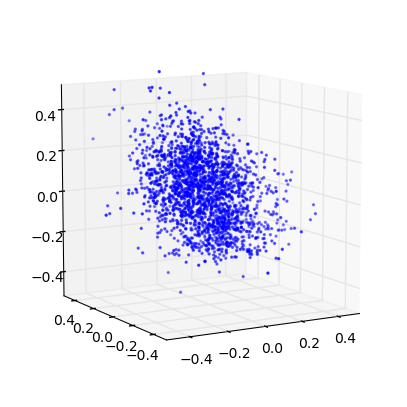

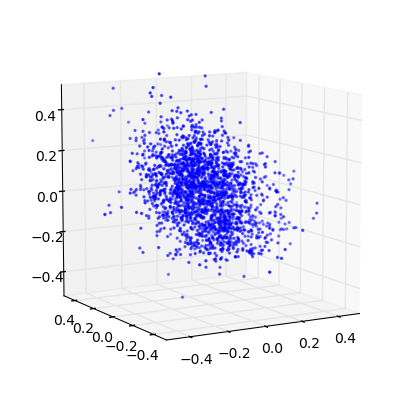

5 (0.0074816858922333819, 4.9506024443584939)


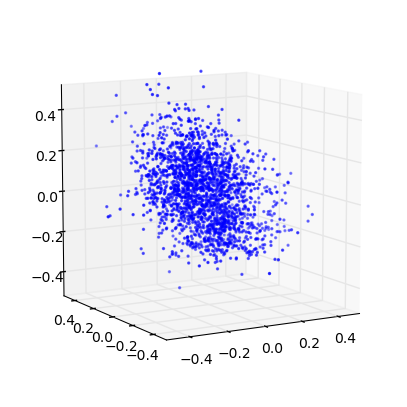

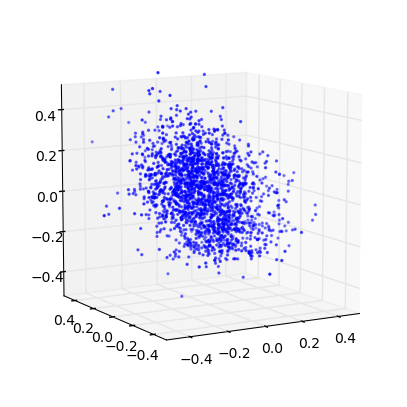

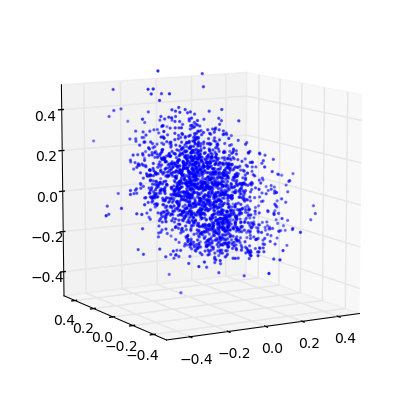

6 (0.0045257018960040548, 5.4611548672551695)
7 (0.010737393707360911, 5.1619968621627148)
8 (0.068795938927518285, 4.2325034468070317)
9 (0.2172421630795883, 3.9883803091214403)
10 (0.23159709627861563, 3.5023094990979069)


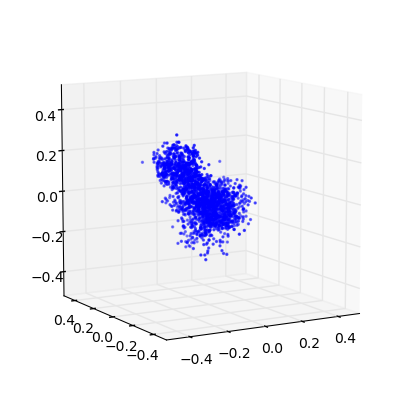

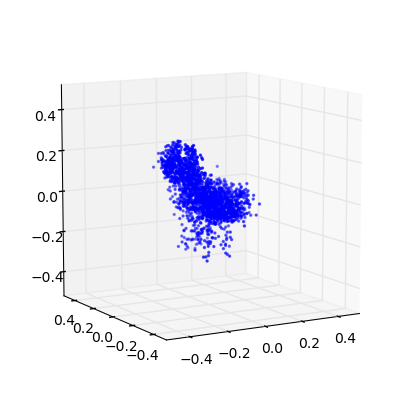

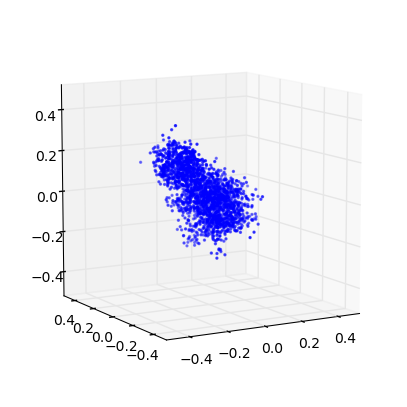

11 (0.6545088288576707, 2.8787273600049641)
12 (0.88404811361561653, 2.1867428317666056)
13 (1.186943370881288, 1.7310712345268415)
14 (1.3786509933679001, 1.4562543804230896)
15 (1.4873591277910316, 1.3300678856994794)
16 (1.6146291732788085, 1.2123842799145244)
17 (1.7282989139142244, 1.1695012963336446)
18 (1.7355433121971462, 1.1147980197616245)
19 (1.7944438136142233, 1.1346344660157743)
20 (1.8248571198919545, 1.1621003547440405)


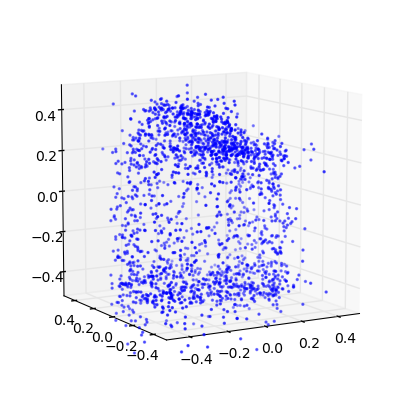

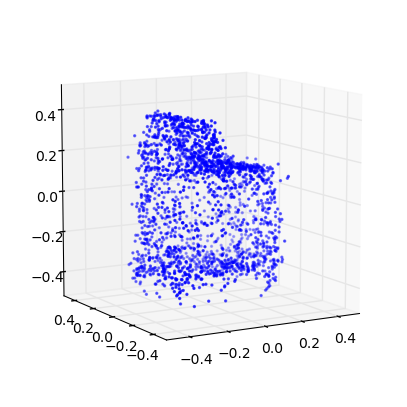

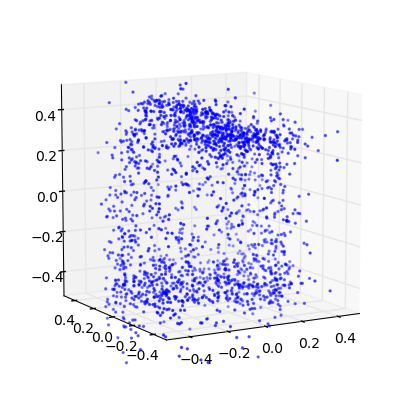

21 (1.8175669815229334, 1.2037079329076021)
22 (1.685523940169293, 1.1985784670580988)
23 (1.6534582511238429, 1.241281653487164)
24 (1.5530260956805686, 1.2287776345792023)
25 (1.4968580670978713, 1.2167674536290376)
26 (1.4180794021357661, 1.2075342206851296)
27 (1.3866761497829272, 1.208026513327723)
28 (1.3668317152106244, 1.2077619588893393)
29 (1.2961798222168632, 1.1639910775682201)
30 (1.248545649777288, 1.1669054233509562)


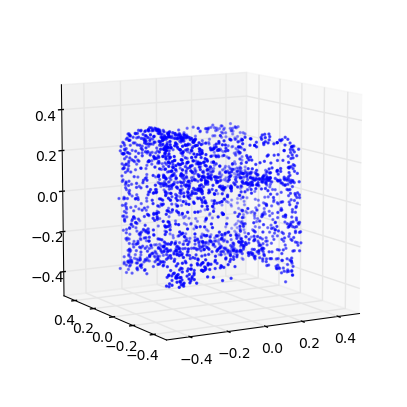

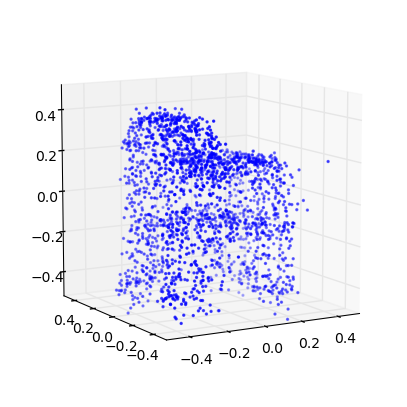

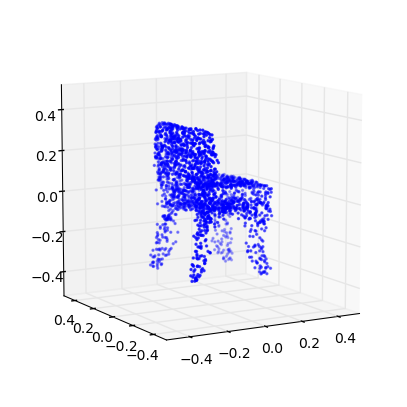

31 (1.2523489019145135, 1.1602399629095326)
32 (1.2221475248751432, 1.1046007814614669)
33 (1.1874941245369288, 1.0256527053273243)
34 (1.1958690010983011, 1.0113963300767153)
35 (1.2070229903511378, 0.98256628539251245)
36 (1.2241566782412321, 0.9413112578184708)
37 (1.2496193792508996, 0.89064323098763176)
38 (1.2746958193571671, 0.83476855132890782)
39 (1.3310655697532323, 0.80985817883325661)
40 (1.3246340834576151, 0.76190188656682556)


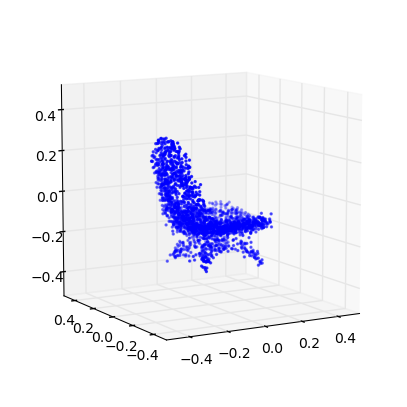

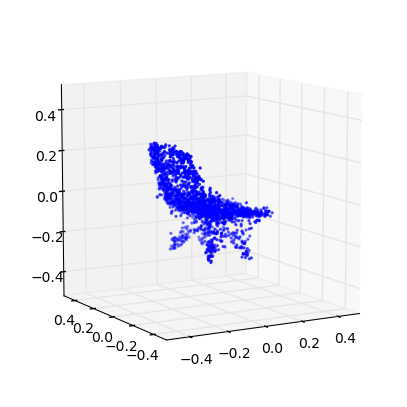

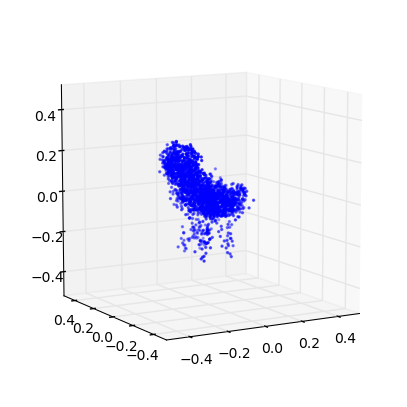

41 (1.3799644418384718, 0.74328340421552241)
42 (1.4001595020294189, 0.7175151801627615)
43 (1.4128527713858563, 0.72682067026262698)
44 (1.4016263723373412, 0.72811771164769712)
45 (1.3917728040529334, 0.75411528685818552)
46 (1.3906986692677374, 0.77187048015387161)
47 (1.3900053749913754, 0.79183020488075584)
48 (1.4019995616829914, 0.79610989637996843)
49 (1.3508780583091404, 0.7827811129715132)
50 (1.3947705517644469, 0.8134780059690061)


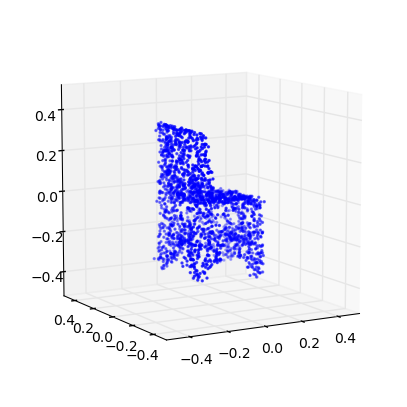

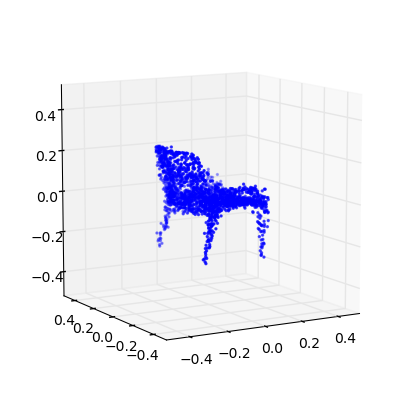

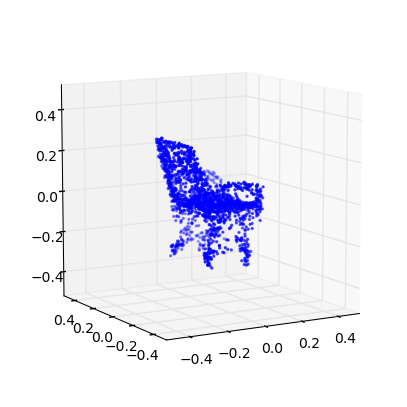

51 (1.39607063687366, 0.82245641843132355)
52 (1.4055828187776649, 0.82705216226370437)
53 (1.359932625812033, 0.81439228990803592)
54 (1.3951410096624624, 0.83843377284381704)
55 (1.3570190522981727, 0.82981378591578936)
56 (1.3350651388582977, 0.81301714441050654)
57 (1.366530298150104, 0.82406097106311638)
58 (1.356945166380509, 0.81885595632636032)
59 (1.3618341217870298, 0.81374273662981778)
60 (1.3250483326289966, 0.79474429125371182)


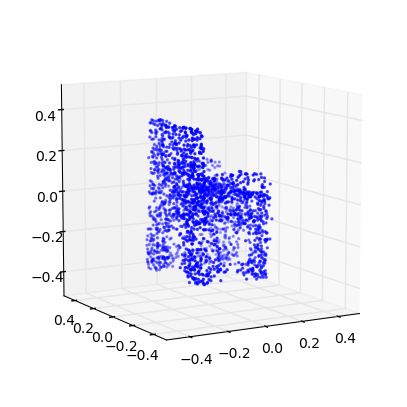

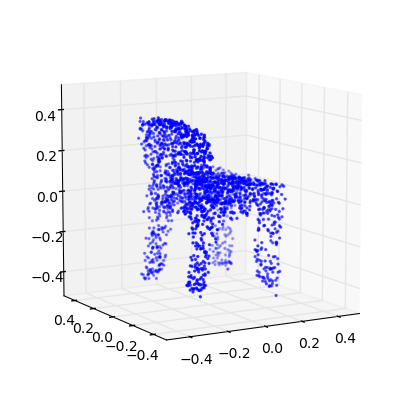

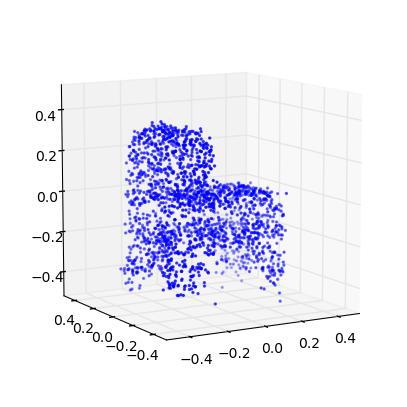

61 (1.3794591426849365, 0.81931045884671416)
62 (1.3442167168078216, 0.79769729505414544)
63 (1.3360051248384559, 0.79408298238464026)
64 (1.3302973239318183, 0.78822453488474309)
65 (1.3406417939973914, 0.79056923182114314)
66 (1.3328571516534558, 0.78774793070295579)
67 (1.3382751340451449, 0.79632831734159715)
68 (1.3309077117754065, 0.79634409132211104)
69 (1.3158250559931215, 0.78947625393452847)
70 (1.3108020658078401, 0.79868649866269981)


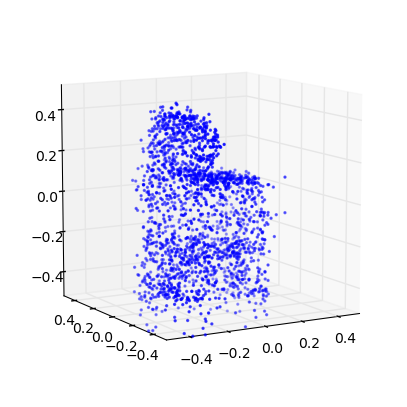

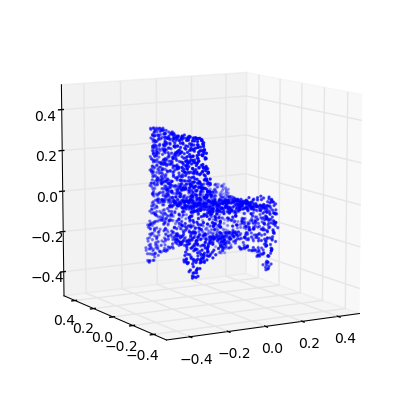

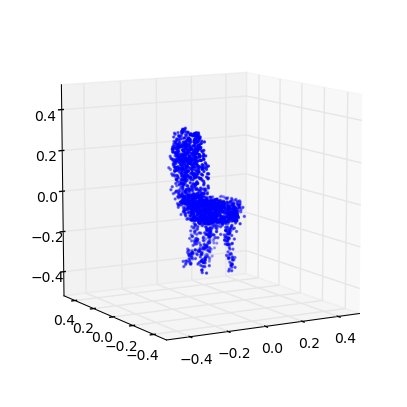

71 (1.377465639943662, 0.83247842374055281)
72 (1.337023255099421, 0.82006816656693171)
73 (1.331041925886403, 0.81410530753757637)
74 (1.326304320667101, 0.81213093607322029)
75 (1.319140891406847, 0.80297967169595796)
76 (1.3187802428784579, 0.81045827321384267)
77 (1.3412725863249406, 0.81351168518481043)
78 (1.320574925256812, 0.80279163381327756)
79 (1.3291679247565891, 0.81247597077618472)
80 (1.3411794154540353, 0.81768238959105122)


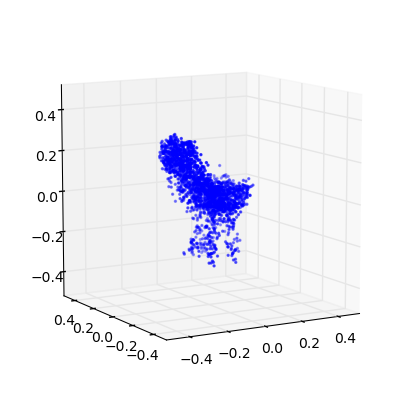

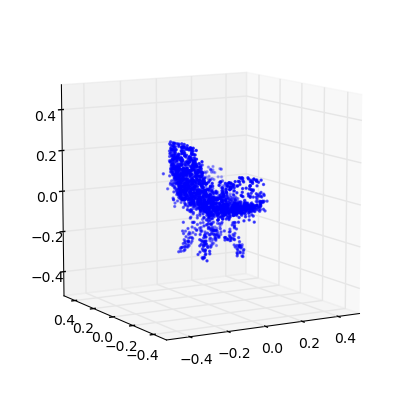

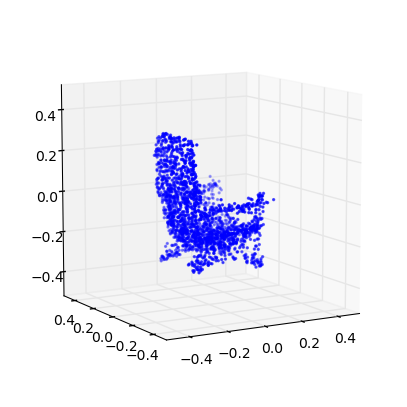

81 (1.334727492539779, 0.802258825302124)
82 (1.3346355303474096, 0.82214119356611504)
83 (1.3152165941570115, 0.80882462107616926)
84 (1.3344674867132436, 0.81979641162830852)
85 (1.3255585556444915, 0.8065130780572477)
86 (1.3318969985713129, 0.81764902809391848)
87 (1.3271292676096378, 0.812820760840955)
88 (1.3130563518275384, 0.80756869627081829)
89 (1.3138932611631311, 0.80713277873785605)
90 (1.3174524949944537, 0.81460643307022429)


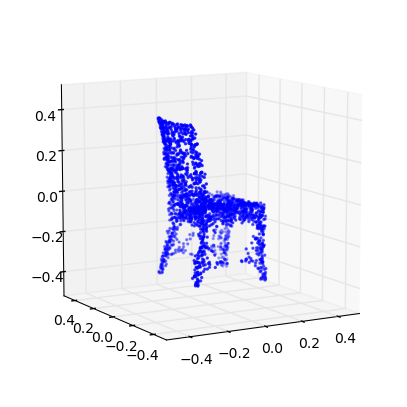

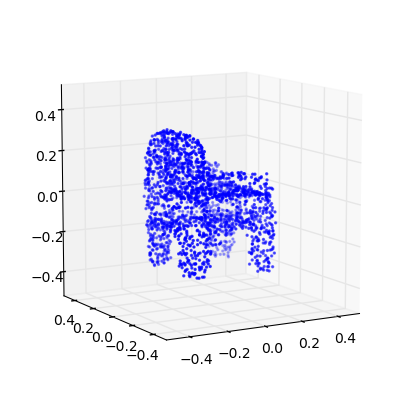

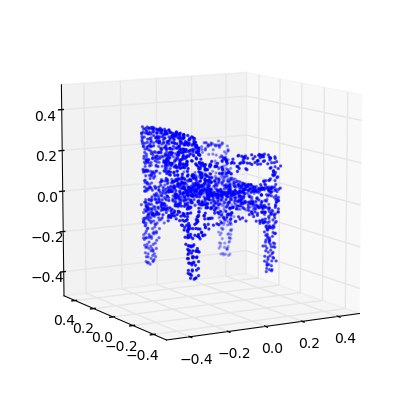

91 (1.3028822691544242, 0.80557981392611633)
92 (1.3125239693600199, 0.81022288462390069)
93 (1.3312568643818732, 0.81591050391611841)
94 (1.3010101276895274, 0.80655173866645147)
95 (1.2948926739070727, 0.80370436958644698)
96 (1.3183389031368753, 0.82256670231404516)
97 (1.3215102278667947, 0.81524360231731252)
98 (1.2922162429146145, 0.8040705629017042)
99 (1.3137312764706819, 0.82036520683247105)
100 (1.2954502727674402, 0.80953292587529058)


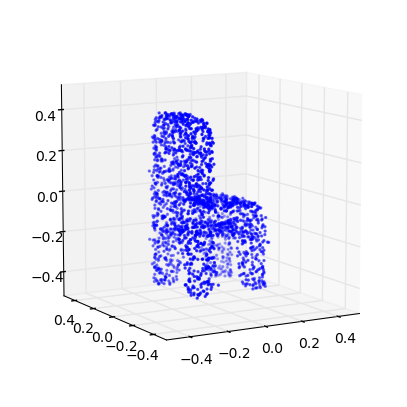

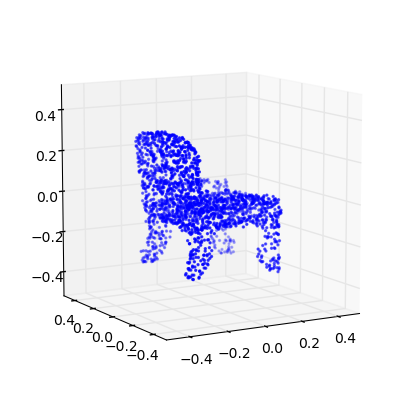

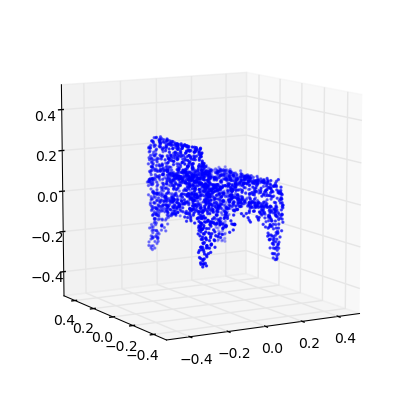

101 (1.300539050931516, 0.81900383208108984)
102 (1.3064627460811449, 0.82499812970990716)
103 (1.2970043586648028, 0.81488216415695525)
104 (1.2922244071960449, 0.81325018535489624)
105 (1.3021415803743446, 0.81309878204179842)
106 (1.2935064284697824, 0.81292210428611089)
107 (1.3064981035564256, 0.81632355373838672)
108 (1.3020221627276876, 0.81818806218064355)
109 (1.2820804772169694, 0.80765194374582039)
110 (1.2871404979539953, 0.81502153199651972)


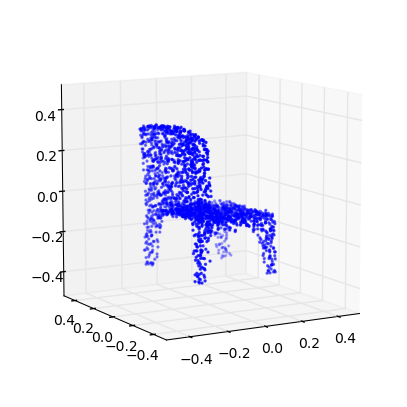

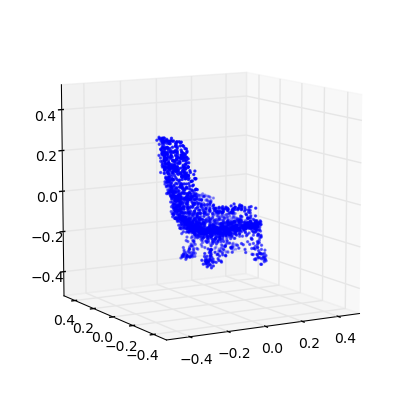

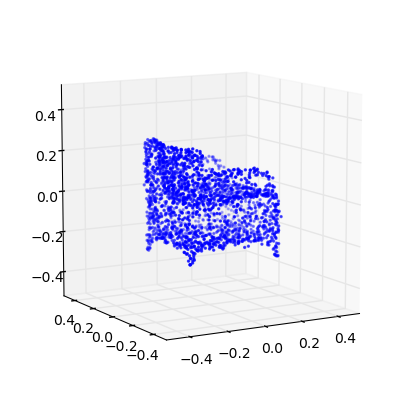

111 (1.295474588352701, 0.82518909625385117)
112 (1.3028469096059385, 0.82221097298290413)
113 (1.2768310349920522, 0.81862716882125186)
114 (1.2871310990789662, 0.81996039877767146)
115 (1.2857001076573911, 0.8251167965971905)
116 (1.274619694378065, 0.82100371640661485)
117 (1.2808717509974603, 0.81992389559745793)
118 (1.2870753485223521, 0.82359464686849848)
119 (1.2873849474865457, 0.81851216450981468)
120 (1.2817637142927751, 0.82081633262012321)


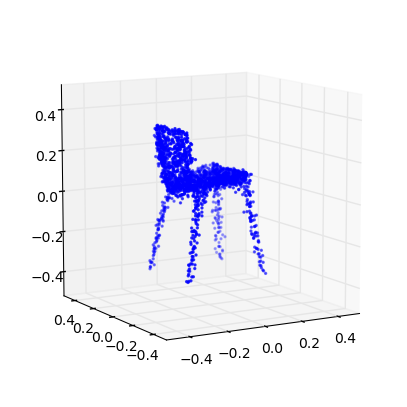

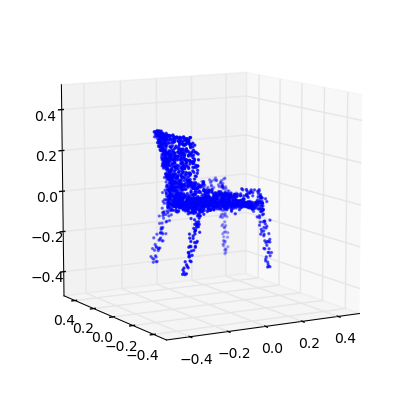

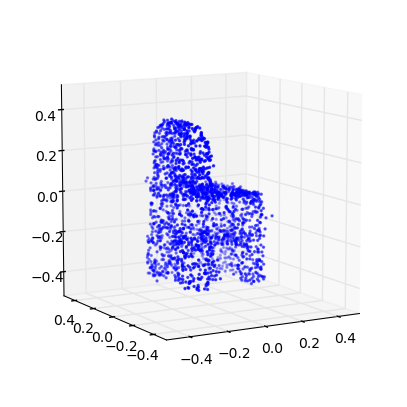

121 (1.2775835317114126, 0.8228595881358437)
122 (1.2796860083289769, 0.82307227642639824)
123 (1.2656828590061353, 0.81594978467277857)
124 (1.2800315214240032, 0.8268782600112583)
125 (1.2662727656571762, 0.82465495674506473)
126 (1.2659257100976031, 0.82623434585073718)
127 (1.2623399661934893, 0.83389537178951756)
128 (1.2597379705180292, 0.83084509942842566)
129 (1.2612378037494161, 0.8405937402144722)
130 (1.256526057616524, 0.83452617914780325)


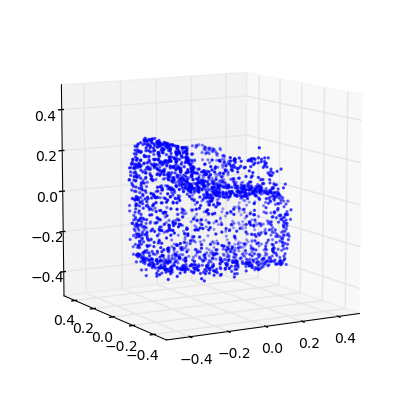

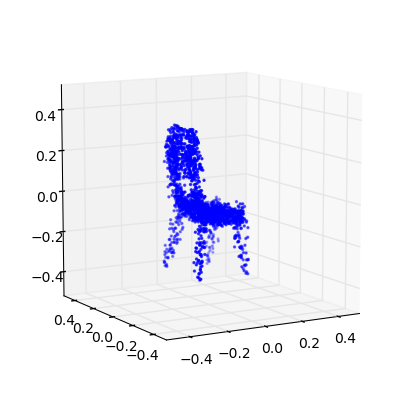

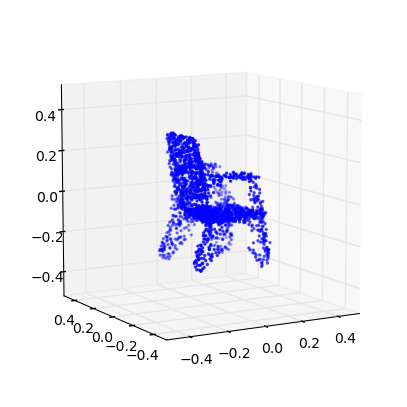

131 (1.2616423886755239, 0.83928293041560964)
132 (1.2520681453787763, 0.84331681598787722)
133 (1.2541837972143421, 0.83749795115512349)
134 (1.2594044073768285, 0.84164423242859221)
135 (1.2565839072932368, 0.8413754364718562)
136 (1.2551572727120441, 0.83987394001172933)


KeyboardInterrupt: 

In [41]:
save_dir = osp.join(synthetic_data_out_dir, experiment_tag)
save_dir = create_dir(save_dir)

if do_training:
    for _ in range(max_epochs):        
        loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss
        
        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
#             gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            syn_latent_data = gan.generate(n_syn_samples, noise_params)
            syn_data = ae.decode(syn_latent_data)
#             np.savez(osp.join(save_dir, 'epoch_' + str(epoch)), syn_data)
            for k in range(3):
                Point_Cloud(syn_data[k]).plot()
            
        train_stats.append((epoch,) + loss)

In [1]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')

NameError: name 'do_plotting' is not defined

In [ ]:
if save_synthetic_samples:

    save_dir = osp.join(synthetic_data_out_dir, experiment_name)
    create_dir(save_dir)
    for i in range(len(accum_syn_data)):
        np.savez(osp.join(save_dir, 'epoch_' + str( (i+1) * saver_step)), accum_syn_data[i])

In [ ]:
epoch_to_check = 5
n_check = 10
check_data = accum_syn_data[epoch_to_check-1]
rids = np.random.choice(range(len(check_data)), size=n_check, replace=False)

for i in range(n_check):
    Point_Cloud(check_data[rids[i]]).plot()